In [ ]:
%%capture
import os, importlib.util

!pip -q install --upgrade uv

# Colab environment: install a consistent torch + pillow stack
if importlib.util.find_spec("torch") is None or "COLAB_" in "".join(os.environ.keys()):
    try:
        import numpy, PIL
        get_numpy = f"numpy=={numpy.__version__}"
        get_pil   = f"pillow=={PIL.__version__}"  # keep existing pillow if present
    except Exception:
        get_numpy = "numpy"
        get_pil   = "pillow<12"                  # block Pillow 12.0.0

    !uv pip install -qqq \
        "torch>=2.8.0" "triton>=3.4.0" {get_numpy} {get_pil} torchvision \
        bitsandbytes "transformers==4.56.2" "trl==0.22.2" peft accelerate datasets \
        "unsloth_zoo[base] @ git+https://github.com/unslothai/unsloth-zoo" \
        "unsloth[base] @ git+https://github.com/unslothai/unsloth"

else:
    # non-colab: just ensure pillow isn't 12.x
    !uv pip install -qqq --upgrade --force-reinstall "pillow<12" unsloth unsloth_zoo


In [ ]:
import unsloth  # ✅ must be first so its patches apply

import os, io, base64, json, math, random
import torch
from PIL import Image
from datasets import Dataset
from huggingface_hub import hf_hub_download
import pyarrow.parquet as pq
from itertools import islice

from unsloth import FastVisionModel, is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from peft import PeftModel
from transformers import AutoProcessor, TextStreamer


{'messages': [{'content': [{'image': None, 'text': 'Identify the main subject (person) in this image as precisely as possible.', 'type': 'text'}, {'image': '', 'text': None, 'type': 'image'}], 'role': 'user'}, {'content': [{'image': None, 'text': 'angela merkel', 'type': 'text'}], 'role': 'assistant'}]}
Train: 1024 | Eval: 256

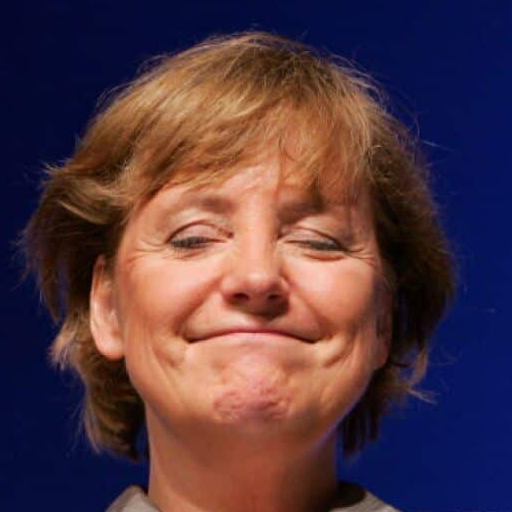

In [ ]:
def bytes_to_data_url(img_bytes: bytes, mime="image/jpeg"):
    b64 = base64.b64encode(img_bytes).decode("utf-8")
    return f"data:{mime};base64,{b64}"

def message_generator(max_shards=6):
    """
    Yields {"messages":[...]} examples:
      user: instruction + image
      assistant: celebrity name
    """
    for shard_id in range(max_shards):
        shard_file = hf_hub_download(
            repo_id="hosiet/famous-figures-25",
            repo_type="dataset",
            filename=f"data/train-0000{shard_id}-of-00006.parquet"
        )
        table = pq.read_table(shard_file)
        images = table.column("image").to_pylist()  # structs with .bytes
        names  = table.column("name").to_pylist()

        for struct, name in zip(images, names):
            img_bytes = struct.get("bytes") if isinstance(struct, dict) else None
            if not img_bytes:
                continue

            try:
                data_url = bytes_to_data_url(img_bytes)
            except Exception:
                continue

            yield {
                "messages": [
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": (
                                    "Identify the main subject (person) "
                                    "in this image as precisely as possible."
                                ),
                            },
                            {"type": "image", "image": data_url},
                        ],
                    },
                    {
                        "role": "assistant",
                        "content": [{"type": "text", "text": str(name)}],
                    },
                ]
            }

# Materialise a small, deterministic subset to avoid iterable edge cases in eval.
N_TOTAL = 1280  # 1024 train + 256 eval
processed_list = list(islice(message_generator(), N_TOTAL))

dataset = Dataset.from_list(processed_list)
train_ds = dataset.select(range(0, 1024))
eval_ds  = dataset.select(range(1024, N_TOTAL))

print(dataset[0])
print(f"Train: {len(train_ds)} | Eval: {len(eval_ds)}")

In [ ]:
import base64, io
from PIL import Image

def decode_data_url(data_url: str) -> Image.Image:
    header, encoded = data_url.split(",", 1)
    data = base64.b64decode(encoded)
    return Image.open(io.BytesIO(data)).convert("RGB")

def prepare_for_unsloth(ds):
    """
    Unsloth vision expected format:
    {
      "messages": [
        {"role":"user", "content":[{"type":"text","text":...}, {"type":"image","image": PIL}]},
        {"role":"assistant","content":[{"type":"text","text":...}]}
      ]
    }
    """
    out = []
    for ex in ds:
        user_msg = ex["messages"][0]
        asst_msg = ex["messages"][1]

        user_text = next(x["text"] for x in user_msg["content"] if x["type"]=="text")
        img_url   = next(x["image"] for x in user_msg["content"] if x["type"]=="image")
        pil_img   = decode_data_url(img_url)

        gold_text = asst_msg["content"][0]["text"]

        out.append({
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text",  "text": user_text},
                        {"type": "image", "image": pil_img},
                    ],
                },
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": gold_text}],
                },
            ]
        })
    return out

train_list = prepare_for_unsloth(train_ds)
eval_list  = prepare_for_unsloth(eval_ds)

print(train_list[0])
print(type(train_list[0]["messages"][0]["content"][1]["image"]))


{'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'Identify the main subject (person) in this image as precisely as possible.'}, {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7E32C41597C0>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'angela merkel'}]}]}
<class 'PIL.Image.Image'>


In [ ]:
model_name = "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit"
model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
processor = AutoProcessor.from_pretrained(model_name)

print("Loaded:", model_name)

==((====))==  Unsloth 2025.11.3: Fast Qwen2_Vl patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Loaded: unsloth/Qwen2-VL-2B-Instruct-bnb-4bit


In [ ]:
if not isinstance(model, PeftModel):
    model = FastVisionModel.get_peft_model(
        model,
        finetune_vision_layers=True,
        finetune_language_layers=True,
        finetune_attention_modules=True,
        finetune_mlp_modules=True,
        r=16,
        lora_alpha=16,
        lora_dropout=0.0,
        bias="none",
        random_state=42,
        use_rslora=False,
        loftq_config=None,
    )


Unsloth: Making `model.base_model.model.model.visual` require gradients


In [ ]:
from unsloth.trainer import UnslothVisionDataCollator

FastVisionModel.for_training(model)

# IMPORTANT: pass tokenizer (not processor) to match Unsloth vision notebooks
base_collator = UnslothVisionDataCollator(
    model, tokenizer,
    train_on_responses_only=True,
    instruction_part="<|im_start|>user",
    response_part   ="<|im_start|>assistant",
)

class FilteredCollator:
    def __init__(self, base): self.base = base
    def __call__(self, features):
        batch = self.base(features)
        batch.pop("num_items_in_batch", None)
        return batch

data_collator = FilteredCollator(base_collator)

Unsloth: Model does not have a default image size - using 512


In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)

data_collator = UnslothVisionDataCollator(
    model, tokenizer,
    train_on_responses_only=True,
    instruction_part="<|im_start|>user",
    response_part   ="<|im_start|>assistant",
)

cfg = SFTConfig(
    output_dir                  = "./results",
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 8,
    max_steps                   = 150,
    learning_rate               = 1e-4,
    weight_decay                = 1e-4,
    bf16                        = is_bf16_supported(),
    fp16                        = not is_bf16_supported(),
    optim                       = "adamw_8bit",
    lr_scheduler_type           = "cosine",
    warmup_ratio                = 0.1,
    max_grad_norm               = 1.0,
    logging_steps               = 10,
    save_strategy               = "steps",
    save_steps                  = 50,
    max_seq_length              = 2048,
    seed                        = 3407,
    report_to                   = "none",

    remove_unused_columns       = False,
    dataset_text_field          = "",
    dataset_kwargs              = {"skip_prepare_dataset": True},
    dataset_num_proc            = 1,
)

trainer = SFTTrainer(
    model         = model,
    tokenizer     = tokenizer,
    data_collator = data_collator,
    train_dataset = train_list,
    eval_dataset  = eval_list,
    args          = cfg,
)


Unsloth: Model does not have a default image size - using 512


In [ ]:
train_result = trainer.train()
print(train_result)

metrics = trainer.evaluate()
print(metrics)


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,024 | Num Epochs = 5 | Total steps = 150
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 28,950,528 of 2,237,936,128 (1.29% trained)


TrainOutput(global_step=150, training_loss=0.15369655325077475, metrics={'train_runtime': 3718.6945, 'train_samples_per_second': 1.291, 'train_steps_per_second': 0.04, 'total_flos': 2.1224852270997504e+16, 'train_loss': 0.15369655325077475, 'epoch': 4.6875})


{'eval_loss': 0.002691002795472741, 'eval_runtime': 70.2673, 'eval_samples_per_second': 3.643, 'eval_steps_per_second': 0.911, 'epoch': 4.6875}


Eval index: 29
Instruction: Identify the main subject (person) in this image as precisely as possible.
GT name    : cristiano ronaldo
Pred (raw) : system
You are a helpful assistant.
user
Identify the main subject (person) in this image as precisely as possible.
assistant
cristiano ronaldo
Match      : ✗


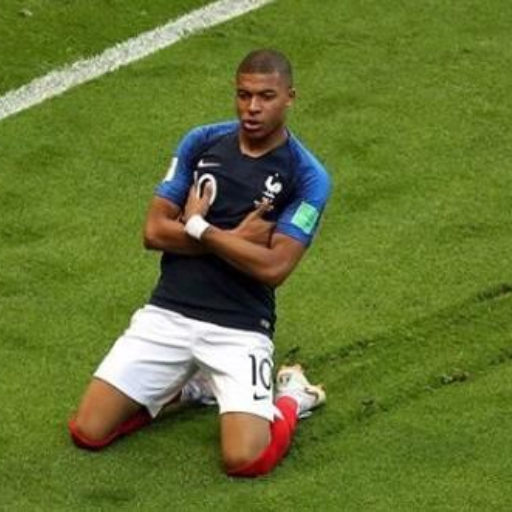

Eval index: 214
Instruction: Identify the main subject (person) in this image as precisely as possible.
GT name    : cristiano ronaldo
Pred (raw) : system
You are a helpful assistant.
user
Identify the main subject (person) in this image as precisely as possible.
assistant
cristiano ronaldo
Match      : ✗


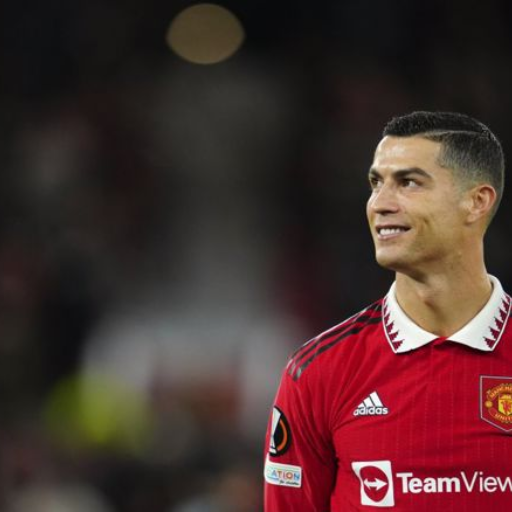

Eval index: 67
Instruction: Identify the main subject (person) in this image as precisely as possible.
GT name    : cristiano ronaldo
Pred (raw) : system
You are a helpful assistant.
user
Identify the main subject (person) in this image as precisely as possible.
assistant
cristiano ronaldo
Match      : ✗


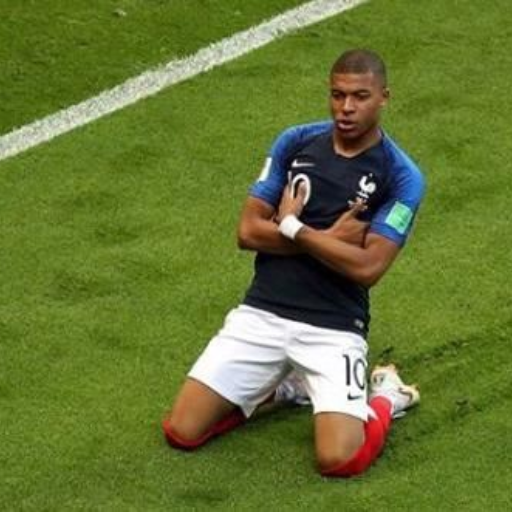

Eval index: 169
Instruction: Identify the main subject (person) in this image as precisely as possible.
GT name    : cristiano ronaldo
Pred (raw) : system
You are a helpful assistant.
user
Identify the main subject (person) in this image as precisely as possible.
assistant
cristiano ronaldo
Match      : ✗


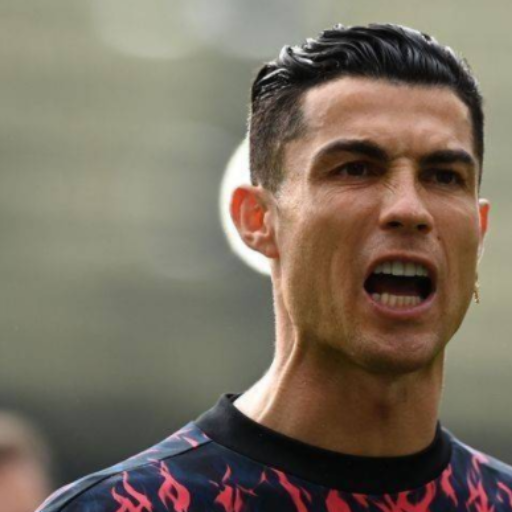

Eval index: 110
Instruction: Identify the main subject (person) in this image as precisely as possible.
GT name    : cristiano ronaldo
Pred (raw) : system
You are a helpful assistant.
user
Identify the main subject (person) in this image as precisely as possible.
assistant
cristiano ronaldo
Match      : ✗


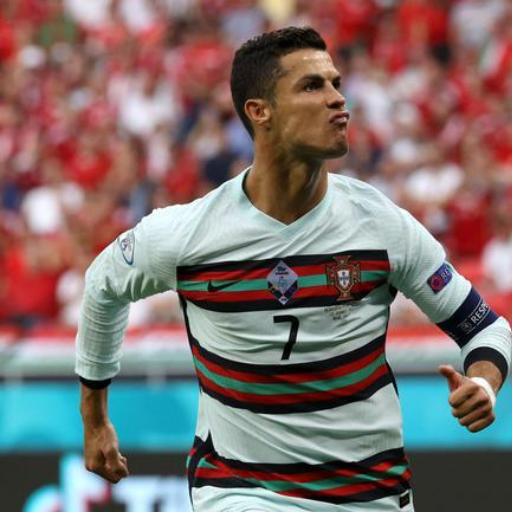

Eval index: 206
Instruction: Identify the main subject (person) in this image as precisely as possible.
GT name    : cristiano ronaldo
Pred (raw) : system
You are a helpful assistant.
user
Identify the main subject (person) in this image as precisely as possible.
assistant
cristiano ronaldo
Match      : ✗


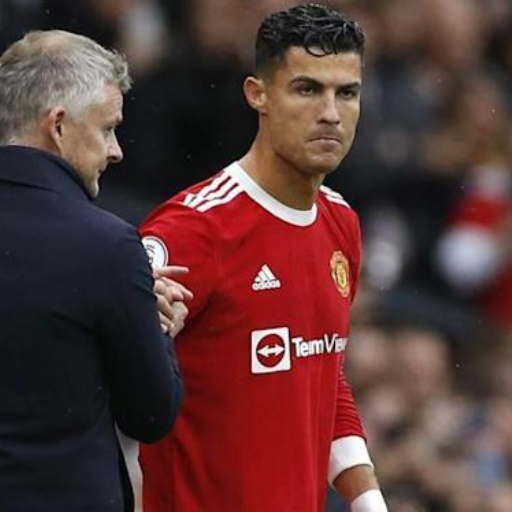

Eval index: 156
Instruction: Identify the main subject (person) in this image as precisely as possible.
GT name    : cristiano ronaldo
Pred (raw) : system
You are a helpful assistant.
user
Identify the main subject (person) in this image as precisely as possible.
assistant
cristiano ronaldo
Match      : ✗


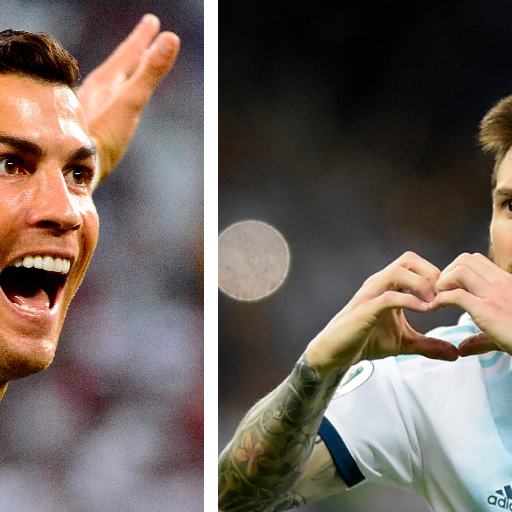

Eval index: 182
Instruction: Identify the main subject (person) in this image as precisely as possible.
GT name    : cristiano ronaldo
Pred (raw) : system
You are a helpful assistant.
user
Identify the main subject (person) in this image as precisely as possible.
assistant
cristiano ronaldo
Match      : ✗


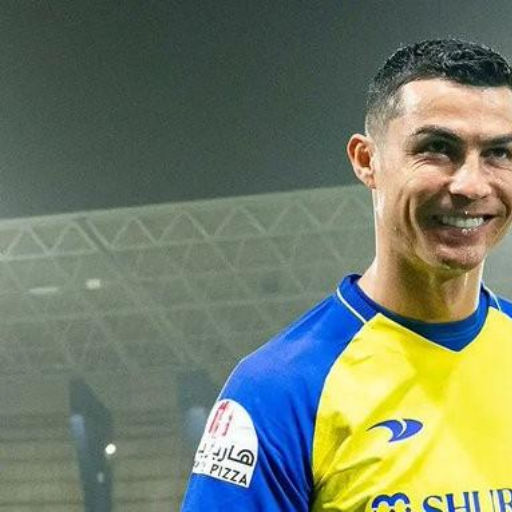


Sample exact-match accuracy: 0/8 = 0.0%


In [ ]:
from IPython.display import display
import random
import torch

FastVisionModel.for_inference(model)

def normalise(s: str) -> str:
    return " ".join(s.lower().strip().split())

@torch.inference_mode()
def predict_on_example(ex, max_new_tokens=24):
    """
    ex is the Unsloth-format dict:
      {"messages": [{"role":"user","content":[text, image]}, {"role":"assistant",...}]}
    """
    user_msg = ex["messages"][0]
    user_text = next(c["text"] for c in user_msg["content"] if c["type"] == "text")
    user_img  = next(c["image"] for c in user_msg["content"] if c["type"] == "image")

    prompt = tokenizer.apply_chat_template(
        [user_msg],  # only user turn
        add_generation_prompt=True
    )

    inputs = processor(
        text=[prompt],
        images=[user_img],
        return_tensors="pt",
        padding=True
    ).to(model.device)

    out = model.generate(**inputs, max_new_tokens=max_new_tokens)
    raw = tokenizer.decode(out[0], skip_special_tokens=True)

    # If the model echoes prompt text, keep tail after assistant tag when present
    if "<|im_start|>assistant" in raw:
        raw = raw.split("<|im_start|>assistant")[-1]
    return raw.strip(), user_text, user_img

# ---- sample & display ----
K = 8
sample_idxs = random.sample(range(len(eval_list)), K)

correct = 0
for idx in sample_idxs:
    ex = eval_list[idx]
    gold = ex["messages"][1]["content"][0]["text"]

    pred_raw, user_text, user_img = predict_on_example(ex)

    ok = normalise(pred_raw) == normalise(gold)
    correct += int(ok)

    print("="*90)
    print(f"Eval index: {idx}")
    print(f"Instruction: {user_text}")
    print(f"GT name    : {gold}")
    print(f"Pred (raw) : {pred_raw}")
    print(f"Match      : {'✓' if ok else '✗'}")
    display(user_img)

print("\nSample exact-match accuracy:",
      f"{correct}/{K} = {correct/K:.1%}")
